In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9fbd19d0d4b0ab4812e1efb898626b4f927849d1133d84c6cc72cc0e454cf605
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=604203525992c8f699dad8b6241d527c8132e40b8b7056c3c55ffb9345134c26
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 28.95 MiB/s, done.


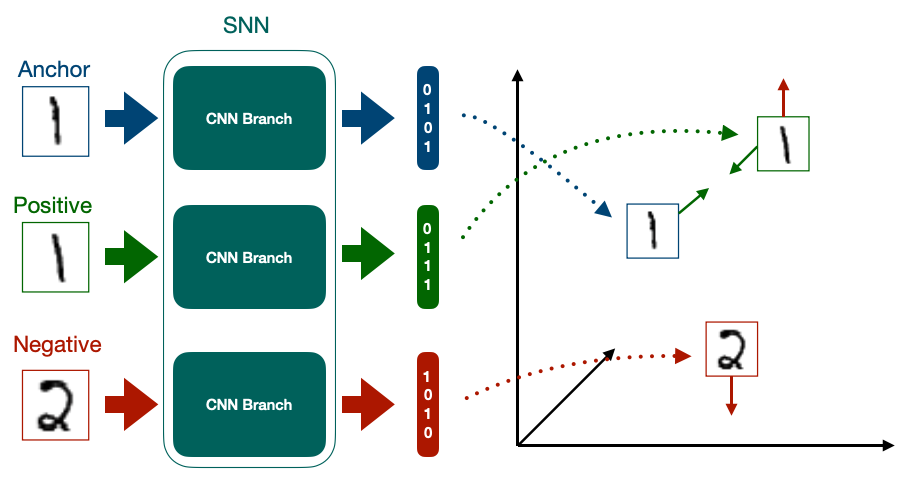

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32 
LR = 0.0001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[45]

In [ ]:
print(row)

Anchor      0384_c5s1_091298_01.jpg
Negative    0570_c3s2_007512_02.jpg
Positive    0384_c1s2_018491_01.jpg
Name: 45, dtype: object


In [ ]:
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

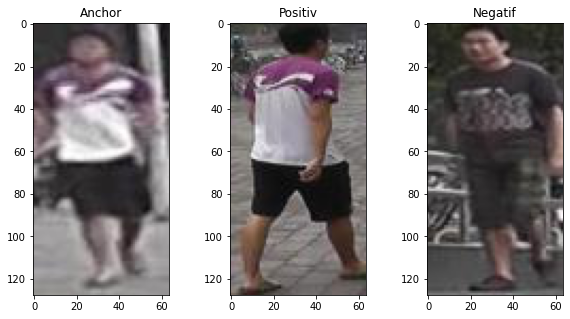

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))
ax1.set_title("Anchor")
ax1.imshow(A_img)
ax2.set_title("Positiv")
ax2.imshow(P_img)
ax3.set_title("Negatif")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# APN Veri setlerini oluşturalım.

In [ ]:
class APN_Dataset(Dataset):
  def __init__(self, df) -> None:
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

    return A_img,P_img,N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"eğitim data'sının boyutu: {len(trainset)}")
print(f"doğrulama data'sının boyutu: {len(validset)}")

eğitim data'sının boyutu: 3200
doğrulama data'sının boyutu: 800


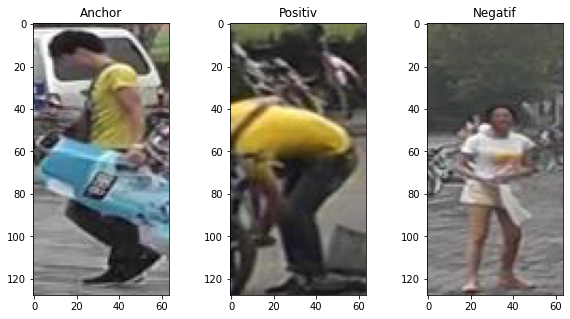

In [ ]:
idx = 40
A,P,N = trainset[idx]
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title("Anchor")
ax1.imshow(A.numpy().transpose((1,2,0)),cmap ='gray')
ax2.set_title("Positiv")
ax2.imshow(P.numpy().transpose((1,2,0)),cmap ='gray')
ax3.set_title("Negatif")
ax3.imshow(N.numpy().transpose((1,2,0)),cmap ='gray')


# Veri setlerini batch'lere yükleme 

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"trainloader batch : {len(trainloader)}")
print(f"validloader batch : {len(validloader)}")

trainloader batch : 100
validloader batch : 25


In [ ]:
for A, P, N in trainloader:
  break;
    
print(f"Veri Kümesini Toplu İşlere Yükleme : {A.shape}")

Veri Kümesini Toplu İşlere Yükleme : torch.Size([32, 3, 128, 64])


# Modeli oluşturma 

In [ ]:
class APN_Model(nn.Module):
  def __init__(self, emb_size = 512):
    super(APN_Model,self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)
  
  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Eğitim ve Değerlendirme fonksiyonunu oluşturalım

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Eğitim döngüsünü oluşturalım

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best.model.pt')
    best_valid_loss = valid_loss
    print("ağırlıklar başarılı şekilde kaydedildi.")

  print(f"EPOCHS: {i+1} TRAIN_LOSS: {train_loss} VALID_LOSS: {valid_loss}")
  


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 1 TRAIN_LOSS: 0.8278805416822433 VALID_LOSS: 0.7743472170829773


100%|██████████| 25/25 [00:02<00:00, 10.99it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 2 TRAIN_LOSS: 0.30270697221159937 VALID_LOSS: 0.5526974380016327


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 3 TRAIN_LOSS: 0.12111232206225395 VALID_LOSS: 0.49193475604057313


100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 4 TRAIN_LOSS: 0.06097655400633812 VALID_LOSS: 0.436119430065155


100%|██████████| 25/25 [00:02<00:00, 11.00it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 5 TRAIN_LOSS: 0.03520637437701225 VALID_LOSS: 0.4334432077407837


100%|██████████| 25/25 [00:02<00:00, 10.72it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 6 TRAIN_LOSS: 0.030849909782409667 VALID_LOSS: 0.4090473365783691


100%|██████████| 25/25 [00:02<00:00, 10.65it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 7 TRAIN_LOSS: 0.01997306406497955 VALID_LOSS: 0.40309109807014465


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 8 TRAIN_LOSS: 0.017665497362613677 VALID_LOSS: 0.400331015586853


100%|██████████| 25/25 [00:02<00:00, 11.17it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 9 TRAIN_LOSS: 0.012188774049282074 VALID_LOSS: 0.37896732091903684


100%|██████████| 25/25 [00:02<00:00, 11.11it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 10 TRAIN_LOSS: 0.01422826886177063 VALID_LOSS: 0.352317214012146


100%|██████████| 25/25 [00:02<00:00, 11.00it/s]


EPOCHS: 11 TRAIN_LOSS: 0.009651756584644318 VALID_LOSS: 0.354236775636673


100%|██████████| 25/25 [00:02<00:00, 10.96it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 12 TRAIN_LOSS: 0.011111425459384918 VALID_LOSS: 0.3497771209478378


100%|██████████| 25/25 [00:02<00:00, 11.05it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 13 TRAIN_LOSS: 0.008349126875400544 VALID_LOSS: 0.3345200288295746


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


ağırlıklar başarılı şekilde kaydedildi.
EPOCHS: 14 TRAIN_LOSS: 0.010243796110153199 VALID_LOSS: 0.3204136872291565


100%|██████████| 25/25 [00:02<00:00, 10.86it/s]

EPOCHS: 15 TRAIN_LOSS: 0.007876056730747222 VALID_LOSS: 0.3260092175006866


# Embeddings'lere bakalım

In [ ]:
def embedding_getir(model,anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR+i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc

In [ ]:
model.load_state_dict(torch.load('best.model.pt'))
df_enc = embedding_getir(model, df['Anchor'])

100%|██████████| 4000/4000 [00:48<00:00, 82.81it/s]


In [ ]:
df_enc.to_csv('database.csv', index = False )
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.308529,0.059655,0.516492,0.386931,0.596278,0.301354,0.309405,0.174373,0.273136,...,0.438271,0.741591,0.458145,-0.153324,0.266114,0.501811,0.327491,-0.131957,0.089634,-0.528771
1,1420_c3s3_061978_03.jpg,-0.191111,0.110661,0.169383,-0.397514,-0.359836,0.595623,0.293296,0.215292,0.800761,...,0.121358,-0.048799,0.381170,0.241852,-0.318320,-0.133778,0.351788,-0.314135,0.214471,0.192005
2,1420_c5s3_062565_05.jpg,-0.251263,-0.879053,0.410234,0.120089,-0.091369,0.711695,-0.205382,-0.658987,0.318554,...,0.559197,-0.054818,-0.060240,-0.273860,-0.111798,0.353944,-0.058179,-0.559442,-0.834478,-0.276595
3,1420_c6s3_085592_04.jpg,0.113775,-0.561310,0.610742,0.493818,-0.174791,0.170649,0.247694,-0.328860,0.755407,...,0.211587,0.175968,0.106356,-0.230287,0.565914,0.434529,-0.212645,-0.734870,0.032919,-0.599915
4,0663_c5s3_085987_03.jpg,0.489149,0.090660,0.587585,-0.059754,-0.364707,0.259169,0.205764,-0.264616,0.351079,...,0.291652,-0.435500,0.226450,-0.117818,0.199487,0.654169,0.170051,0.217558,-0.333421,-0.556670


# Çıkarım

In [ ]:
def oklid_mesafesi(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = oklid_mesafesi(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.8/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


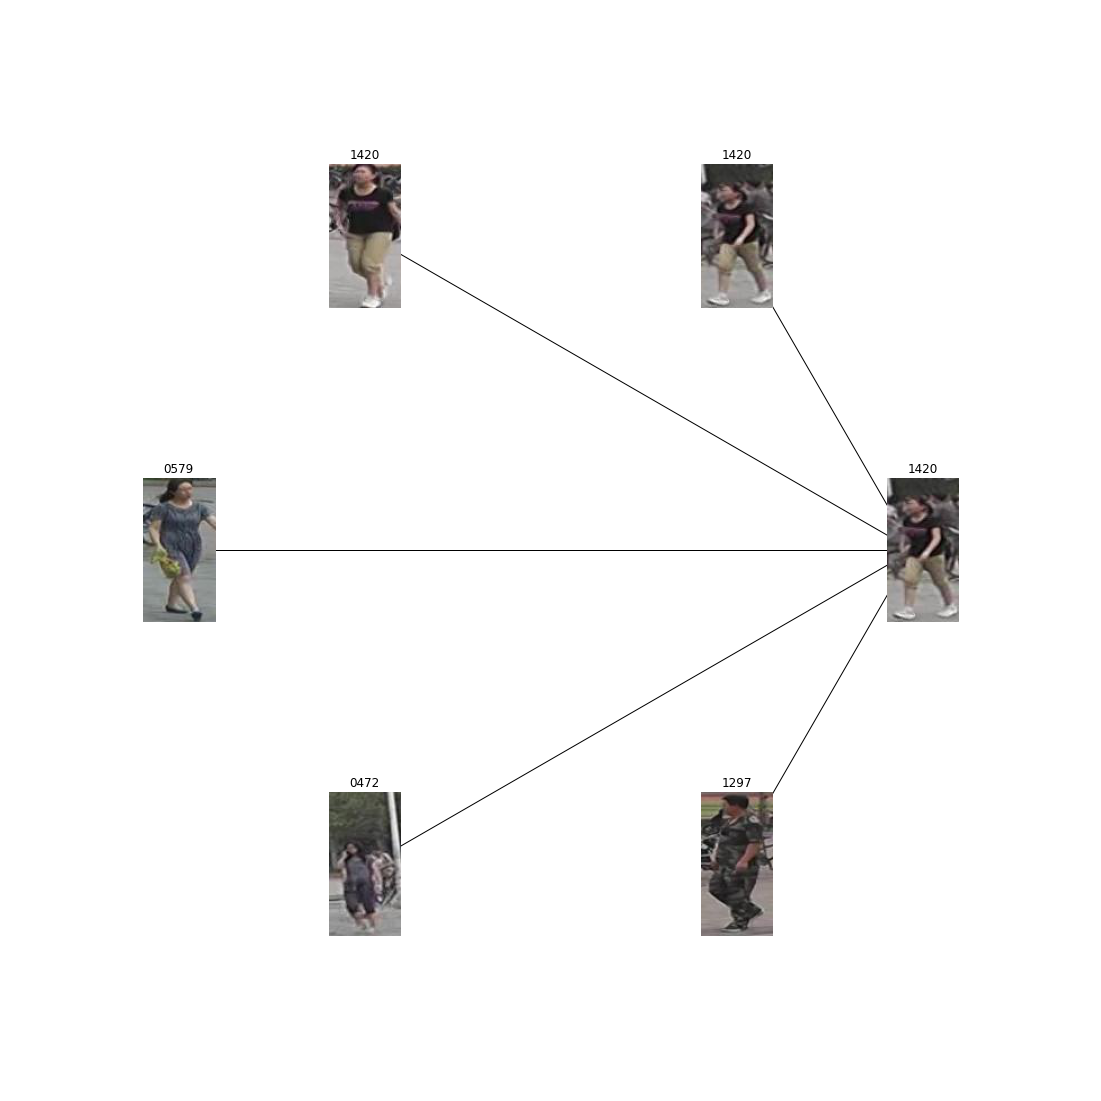

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);